## Notas de clase virtual 3
###### Por: Gabriel Missael Barco, 24/04/2020

Se busca que la **fracción de aceptación** este en el intervalo `[0.2, 0.5]`, esto expresa que fraccion e tus pasos en la cadena se estan aceptando. Si es muy pequeño, se esta avanzando con mucha dificultad (i.e no converge); en cambio si es muy alta, se esta recorriendo el espacio de parametros de manera casí uniforme.

Es recomendable corre **cadenas largas**, para obtener una mejor nube de probabilidad y asegurar convergencia, aunque en realidad el numero de pasos depende totalmente del tipo de problema que estemos atacando, por ejemplo, del numero de parametros y sus caracteristicas. Tambien es recomendable correr **varias cadenas**.

Despues de tener la cadena, es necesario cortar los pasos iniciales hasta que se llegue a la zona de alta probabilidad, lo que se denomina como **burning**. Para esto nos podemos apoyar de las graficas de valor vs. paso para cada uno de los parametros.

Existen varias condiciones cuantitativas para determianar si una cadena ha **convergido** o no. Un metodo cuantitativo para conocer si el metodo a convergido es el [diagnostico Gelman-Rubin](https://projecteuclid.org/download/pdf_1/euclid.ss/1177011136).

Si el codigo esta bien programado y las $\sigma$ estan elegidas bien, teoricamente las cadenas *siempre* convergen en un tiempo infinito.

Una vez que tenemos la cadena generada y una vez que retiramos el **burning**, para elegir que valor reportar, debemos tomar la media y tomar la desviacion estandar. Esto es idealmente, en caso de obtener una distribución gaussiana. En caso contrario, depende de que resultado obtengamos; esta 'decición'la podemos apoyar graficando todos los histrogramas 2d y 1d de todos los parametros para visualizar que decisiones serian optimas.

Los cambios implementados esta semana al codigo han sido:
1. Definir el prior
2. Utilizar funcion mcmc con prior en lugar de likelihood
3. Hacer funcion que grafique histogramas 2d junto con histogramas individuales (triangle plot) (Sugerencias de librerias: corner, getdist) esto se hace de las n cadenas juntas.
4. Hacer funcion que grafique valor vs paso para seleccionar corte de burning
5. Implementar Gelman-Rubin
6. Implementar pausa de tiempo

Un sitio util para leer hacerca de MCMC es [este](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from getdist import plots, MCSamples
import getdist

## Funciones de prior y likelihood necesarias

In [27]:
def ln_prior(parametros):
    '''
    DESCRIPTION: Esta funcion regresa el prios de un conjunto de parametros dados para el modelo
    IN: parametros = lista de parametros
    OUT: lista con numeros flotantes igual a la probabilidad
    
    Nota: en este caso elegimos una probabilidad continua para cada parametro
    '''
    inf = [3, -2]
    sup = [17, 12]
    p = np.zeros(2)
    
    for i in range(2):
        if inf[i]<parametros[i]<sup[i]:
            p[i] = -1*np.log(sup[i]-inf[i])
        else:
            p[i] = 0
    
    return sum(p)


def ln_likelihood(datos, parametros, teoria, desviacion_teoria, modelo):
    '''
    DESCRIPTION: Esta funcion regresa un valor proporcional al likelihood
    IN: datos = las x, variable independiente,
        parametros = parametros del modelo
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo
    OUT: Numero flotante proporcional al liklihood de los parametros dados
    '''
    #Inicializamos la suma
    suma = 0
    
    #Sumamos cada elemento
    for i in range (len(datos)):
        suma += (teoria[i]-modelo(datos[i], parametros))**2/desviacion_teoria[i]**2
    return -(1/2)*suma

## Funcion que genera las cadenas de Markov con el metodo de Monte Carlo

In [54]:
def montecarlo_mc(N, datos, teoria, desviacion_teoria, modelo, desviacion_parametros, p_old, n_pasos=500, seed = 500):
    '''
    REQUIREMENTS: Numpy
    DESCRIPTION: Esta funcion aplica el metodo de montecarlo para obtener los valores
                 mas probables de determinados parametros de un modelo aplicado a
                 ciertos datos conocidos.
    IN: N = numero de cadenas deseadas
        datos = las x, variable independiente,
        teoria = las y, variable dependiente,
        desviacion_teoria = desviacion de las y,
        modelo = funcion que aplica el modelo,
        desviacion_parametros = desviacion estandar conocidas para cada parametro,
        p_old = N aproximaciónes iniciales,
        n_pasos = numero de pasos,
        seed = semilla de numeros aleatorios
    OUT: cadena de markov con posterior asociados, y un valor booleano de si el parametro fue aceptado o no,
         esto en cada parametro de la cadena.
    '''
    #Creamos lista donde estarán las cadenas
    markov_matrix = []
    
    #Corremos N veces para obtener n cadenas
    for i_cadena in range(N):
        
        #Para tener datos reproducibles, damos un seed para los numeros aleatorios
        np.random.seed(seed)

        #Inicializamos la cadena de markov
        markov_chain = []

        #agregamos el primer conjunto de parametros y su likelihood
        ln_post_old = ln_likelihood(datos, p_old[i_cadena], teoria, desviacion_teoria, modelo)+ln_prior(p_old[i_cadena])
        markov_chain.append([p_old[i_cadena], ln_post_old, True])

        #Realizamos n iteraciones
        for paso in range(n_pasos):

            #Lista para nuevo parametro
            p_new = []

            #Llenamos p_new con una distribución aleatoria normal
            for j, parametro in enumerate(p_old[i_cadena]):
                p_new.append(desviacion_parametros[j]*np.random.randn()+parametro)

            #Calculamos nuevo likelihood
            ln_post_new = ln_likelihood(datos, p_new, teoria, desviacion_teoria, modelo)+ln_prior(p_new)

            #Guardamos nuevo punto, su likelihood y si lo aceptamos o no segun las condiciones
            if (ln_post_new>ln_post_old):
                markov_chain.append([p_new, ln_post_new, True])
                p_old[i_cadena] = p_new
                ln_post_old = ln_post_new
            elif  ln_post_new-ln_post_old > np.random.randn(): #Este exponencial no va, pero no pude implementar el prior
                markov_chain.append([p_new, ln_post_new, True])
                p_old[i_cadena] = p_new
                ln_ost_old = ln_post_new
            else:
                markov_chain.append([p_new, ln_post_new, False])
  
        #Agregamos la cadena de esta iteración a la lista de cadenas
        markov_matrix.append(markov_chain)
            
    else:
        return markov_matrix

## Funciones de diagnostico y resultado

In [5]:
def aceptacion(cadenas):
    '''
    DESCRIPTION: Obtiene fracción de aceptación de las cadenas de Markov
    IN: cadenas = lista de cadenas de markov
    OUT: lista con fraccion de aceptacion de cada cadena (en orden)
    '''
    #Obtengo el numero de puntos aceptados en cada cadena
    
    N = len(cadenas)
    
    aceptacion = np.zeros(N)
    for i, cadena in enumerate(cadenas):
        for p, post, a in cadena:
            aceptacion[i] += a
            
    #Calculamos la fraccion de aceptacion
    ratio = np.zeros(N)
    pruebas = len(cadenas[0])

    for i in range(N):
        ratio[i] = aceptacion[i]/pruebas
        print(f'Aceptación de cadena {i} = {ratio[i]}')
    
    return ratio

In [6]:
def gelman_rubin(cadenas, cut=0):
    
    '''
    DESCRIPTION: Se realiza el diagnostico de Gelman-Rubin para todos los parametros
    IN: cadenas = cadenas de markov
        cuts = cortes del burning
    OUT: Medida de convergencia de cada parametro
    '''
    
    #Sacamos los datos para manipularlos facilmente
    cad = []
    for i, cadena in enumerate(cadenas):
        cad.append([])
        for p, post, a in cadena:
            cad[i].append(p)
            
    cad = np.array(cad)
    
    #Realizamos el diagnostico Gelman-Rubin
    
    p = len(cad[0][0]) #numero de parametros
    m = len(cad) #numero de cadenas
    n = len(cad[0][cut:]) #elementos de la cadena sin el burning
    
    R = [] #lista de medida de convergencia
    
    for i in range(p):
        s_c = []
        media = []
        
        for j in range(m):
            s_c.append(0)
            media.append(np.average((cad[j][cut:].T)[i])) #media del parametro en esa cadena
            
            for x in cad[j][cut:][i]:
                s_c[j] += (x-media[j])**2 
            s_c[j] /= (n-1)
            
        s = sum(s_c)/m
        
        Bn = 0
        miu = np.average(np.array(media))
        
        for x in media:
            Bn += (x-miu)**2
        Bn /= (m-1)
        
        sigma = (n-1)/n*s+Bn
        
        R.append((sigma/s)**(1/2))
        print(f'Para el parametro {i}, R = {R[i]:.5}')
        
    return R

In [7]:
def resultados(datos):
    '''
    Esta funcion regresa las medias y los intervalos de confianza para los parametros
    IN: datos = Lista de puntos de parametros
    OUT: Lista de elementos de la forma [media i, inf_i, sup_i], para cada parametro
    '''
    N = len(datos[0])
    parametro = [[] for x in range(N)]
    
    for punto in datos:
        for i, p in enumerate(punto):
            parametro[i].append(p)
            
    R = []
    for i in range(N):
        R.append([])
        R[i].append(np.percentile(parametro[i], 50))
        R[i].append(np.percentile(parametro[i], 16))
        R[i].append(np.percentile(parametro[i], 84))
    
    for i, parametro in enumerate(R):
        print(f'Parametro {i} = {parametro[0]:.4} ± ({parametro[0]-parametro[1]:.4}, {parametro[2]-parametro[0]:.4})')
    
    return R

## Funciones para visualizacion

In [8]:
def ver_cadenas(cadenas, i_parametro, p_reales=[]):
    '''
    DESCRIPTION: Muestra graficamente las cadenas de markov generadas, visualizando solo dos parametros
    IN : cadenas = lista con N cadenas, cada una con M elementos de la forma [[parametros], likelihood, accepted]
         i_parametros = lista de dos numeros igual al indice de los parametros que se quieren mostrar
         p_reales = lista con valores reales de todos los parametro (en orden)
    OUT: Plot con cadenas de markov sobre dos paramtros
    '''
    # Extraemos los datos
    x = []
    y = []

    for i, cadena in enumerate(cadenas):
        x.append([])
        y.append([])
        for dato, post, accept in cadena:
            x[i].append(dato[i_parametro[0]])
            y[i].append(dato[i_parametro[1]])

    
    #Creamos figura
    fig, ax0 = plt.subplots(figsize=(6, 6))

    #Graficamos todas las cadenas enviadas
    for i in range(len(cadenas)):
        ax0.scatter(x[i], y[i], marker = 'o', label = 'Cadena '+str(i+1), alpha = 0.2)

    #Si se envian los parametros enviados, se muestran en la gráfica
    if (p_reales != []):
        plt.plot(p_reales[i_parametro[0]], p_reales[i_parametro[1]], marker = 's', label = 'Valor real', c = 'black')
        
    #Detalles de la gráfica
    ax0.set_ylabel(f'Parametro {i_parametro[1]}')
    ax0.set_xlabel(f'Parametro {i_parametro[0]}')
    ax0.grid()
    plt.legend()
    plt.title(f'MCMC aplicado al modelo')

    plt.show()

In [9]:
def ver_parametros(cadena, i_parametros = [], cut = 0):
    '''
    DESCRIPTION: Sirve para observar la variacion de los parametros a lo largo de los pasos de UNA SOLA CADENA
                 y poder decidir el corte del burning para cada cadena
    IN: cadenas = lista de una cadena de markov
        i_parametros = indice de parametros a mostrar (dafault = todos)
        cut = paso a partir del que se grafica (esto es util para elegir donde cortar el burnin)
    OUT: N plots de N parametros vs pasos de la cadenas
    '''
    #Saco listas de cada parametro de la cadena (en orden)
    N = len(cadena[0][0])
    plot_parametro = [[] for i in range(N)]
    pasos = [x for x in range(len(cadena))]

    for p, post, a in cadena:
        for i, parametro in enumerate(p):
            plot_parametro[i].append(parametro)

    #Si no se especifica, se grafican todos       
    if(i_parametros == []):
        i_parametros = [x for x in range(N)]
    
    #Creo figura con una subplot para cada parametro
    fig, axs = plt.subplots(len(i_parametros), 1, sharex=True, figsize = (10, N*2))
    fig.subplots_adjust(hspace=0)
    
    #Graficamos
    axs[0].set_title(f'Parametros a cada paso (Intervalo = [{cut},{len(cadena)}])')
    for i, index in enumerate(i_parametros):
        
        media = np.percentile(np.array(plot_parametro[index][cut:]), 50)
        axs[i].plot(pasos[cut:], plot_parametro[index][cut:])
        axs[i].plot(pasos[cut:], [media for x in range(len(pasos[cut:]))], linewidth=2.0)
        
        axs[i].grid()
        axs[i].set_ylabel(f'Parametro {index}')
        
    axs[N-1].set_xlabel('Pasos')
    plt.show()

In [10]:
def hist2d(datos, i_param, bins=100):
    '''
    DESCRIPTION: Esta funcion genera un histograma 2d de dos parametros dados
    IN: datos = Lista con puntos de parametros
        i_param = lista indices de los dos parametros a graficar
    OUT = plot histograma 2d con colorbar inferno  
    '''
    
    #Obtenemos listas de ambos parametros
    x = []
    y = []
    for punto in datos:
        x.append(punto[i_param[0]])
        y.append(punto[i_param[1]])
    
    #Graficamos
    plt.hist2d(x, y, bins = bins, cmap = 'inferno')
    plt.ylabel(f'Parametro {i_param[1]}')
    plt.xlabel(f'Parametro {i_param[0]}')
    plt.colorbar(label = 'Frecuencia')
    plt.show()

In [11]:
def triangulo(datos, labels = []):
    '''
    DESCRIPTION: Esta funcion realiza una grafica triangular para visualizar los resultados
    IN: datos = lista con puntos de datos (cada uno es una lista con valores para cada parametro)
        labels = nombre de los parametros (default p_i)
    OUT: Grafica triangular con histogramas 1d y 2d de todas la combinaciones
    '''
    g = plots.get_subplot_plotter(subplot_size=3)
    
    #Checamos si se asignó nombre a los parametros
    if labels!=[]:
        samples = MCSamples(samples=np.array(datos), labels = labels, names = labels)
    
    else:
        samples = MCSamples(samples=np.array(datos))
    
    #graficamos
    g.triangle_plot(samples, filled=True, title_limit=1)

### Funcion para juntar cadenas 

In [12]:
def unir_cadenas(cadenas, cuts):
    '''
    DESCRIPTION: Esta funcion une los datos de todas las cadenas, ignorando los cortados por el burning
    IN: cadenas = Lista de cadenas de markov
        cuts = lista con paso de corte por burning de cada cadena
    OUT: lista con datos de las cadenas
    '''
    #Extraemos los datos de las cadenas ignorando el burning
    datos = []
    
    for i, cadena in enumerate(cadenas):
        for p, post, a in cadena[cuts[i]:]:
            datos.append(p)
            
    return datos

# Prueba con una recta

In [85]:
# Definimos el modelo que aplicamos, que es una recta
def recta(x, parametros):
    return x*parametros[0]+parametros[1]

#Parametros y sus desviaciones
p_reales = [10, 5]
des_p = [0.07, 0.07]

#Construimos la recta:
x = np.linspace(0, 10, 1000)
y = x*p_reales[0]+p_reales[1]
des_y = [0.1 for punto in range(len(y))]

#Establecemos los N parametros iniciales que usaremos
p_iniciales = [[5, 10],[7, 13], [15, 13], [15, 7], [7, 7]]

#Aplicamos el mcmc
cadenas = montecarlo_mc(N = 5, datos = x, desviacion_teoria = des_y, teoria = y, 
                       modelo = recta, desviacion_parametros = des_p, p_old = p_iniciales, n_pasos = 4000)

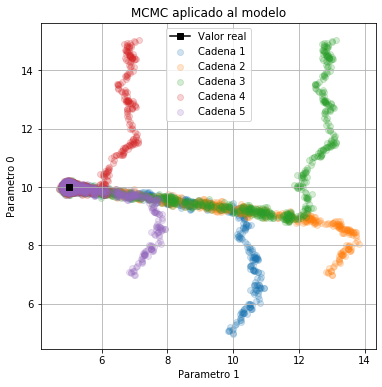

In [86]:
ver_cadenas(cadenas = cadenas[0:5], i_parametro = [1,0], p_reales = p_reales)

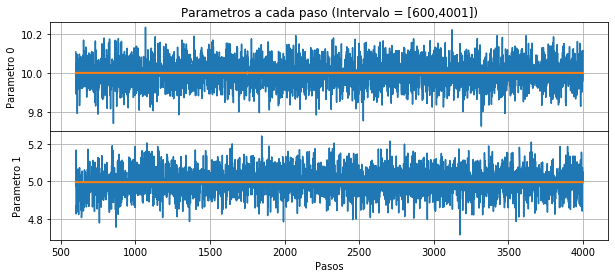

In [87]:
ver_parametros(cadena = cadenas[0], cut = 600)

In [88]:
ratio = aceptacion(cadenas)

Aceptación de cadena 0 = 0.04448887778055486
Aceptación de cadena 1 = 0.04498875281179705
Aceptación de cadena 2 = 0.06298425393651587
Aceptación de cadena 3 = 0.030992251937015745
Aceptación de cadena 4 = 0.022994251437140716


In [89]:
datos = unir_cadenas(cadenas, cuts = [900 for x in range(5)])

Removed no burn in


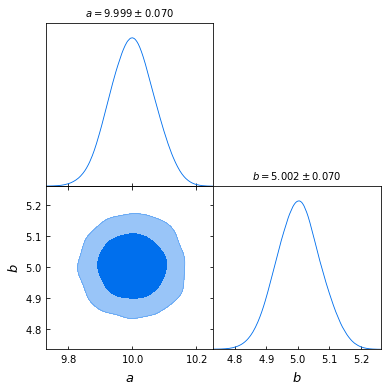

In [90]:
triangulo(datos, ['a', 'b'])

In [91]:
r = resultados(datos)

Parametro 0 = 9.999 ± (0.06968, 0.07106)
Parametro 1 = 5.002 ± (0.07, 0.07035)


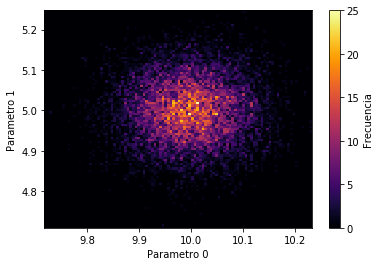

In [92]:
hist2d(datos, [0,1])

In [93]:
convergencia = gelman_rubin(cadenas, cut = 600)

Para el parametro 0, R = 1.0003
Para el parametro 1, R = 1.0119


# Implementacion con galaxias

Por hacer:
1. Definir el prior
2. Utilizar funcion mcmc con prior en lugar de likelihood
3. Hacer funcion que grafique histogramas 2d junto con histogramas individuales (triangle plot) (Sugerencias de librerias: corner, getdist) esto se hace de las n cadenas juntas.
4. Hacer funcion que grafique valor vs paso para seleccionar corte de burning
5. Implementar Gelman-Rubin
6. Implementar pausa de tiempo